# Homework 7: scikit-image

Sam Badman - 4/5/18

Due Tuesday Apr 10, 6pm

## Problem 1 : Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

## Solution

### Read in image

Image Dimensions:  (303, 384)  Image Datatype:  uint8


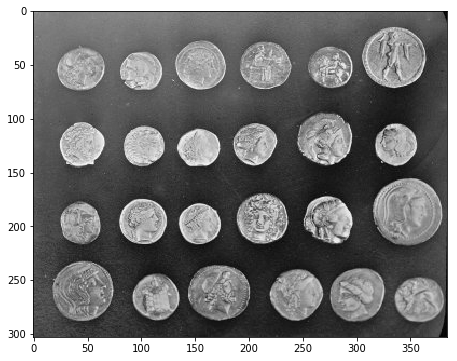

In [1]:
%matplotlib inline
import skimage.data as data
import matplotlib.pyplot as plt
coin_im = data.coins()
plt.figure(figsize=(10,6))
plt.imshow(coin_im,cmap='gray')
print('Image Dimensions: ',coin_im.shape,' Image Datatype: ',coin_im.dtype)
# Note the image is grayscale and unsigned byte data

### Equalize image

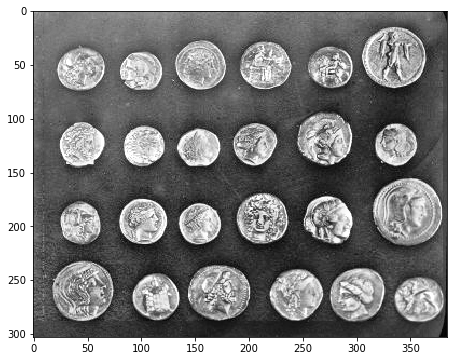

In [2]:
from skimage import exposure
coin_im_equalized = exposure.equalize_adapthist(coin_im,kernel_size = [20,20])
plt.figure(figsize=(10,6))
plt.imshow(coin_im_equalized,cmap='gray')

### Threshold Image

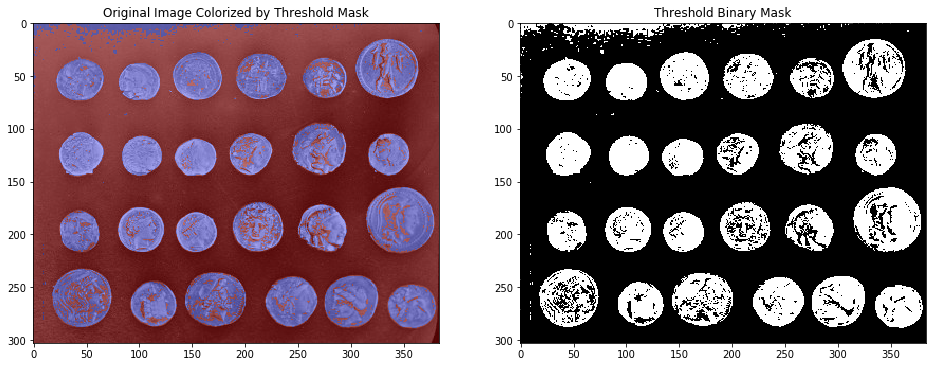

In [3]:
from skimage import filters
from skimage.color import label2rgb as l2rgb
import numpy as np
# Identify threshold value to define background
threshold_val = filters.threshold_otsu(coin_im_equalized)
# Return image with background pixels set to 0
foreground_mask = coin_im_equalized >= threshold_val
# Plot thresholded mask on top of original image
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(l2rgb(foreground_mask,coin_im))
plt.title('Original Image Colorized by Threshold Mask')
plt.subplot(122)
plt.title('Threshold Binary Mask')
plt.imshow(foreground_mask,cmap='gray')

### Remove Objects Touching the Boundary

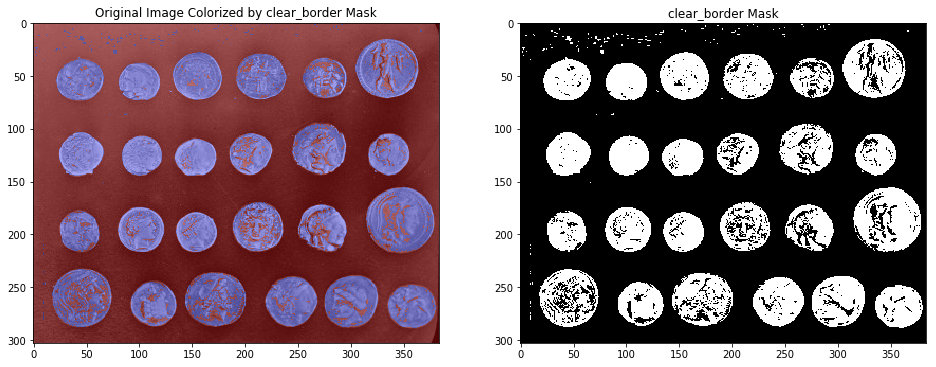

In [4]:
from skimage import segmentation
clear_boundary_mask = segmentation.clear_border(foreground_mask,buffer_size=1)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.title('Original Image Colorized by clear_border Mask')
plt.imshow(l2rgb(clear_boundary_mask,coin_im))
plt.subplot(122)
plt.title('clear_border Mask')
plt.imshow(clear_boundary_mask,cmap='gray')

### Apply Morphological Closing to remove small spots

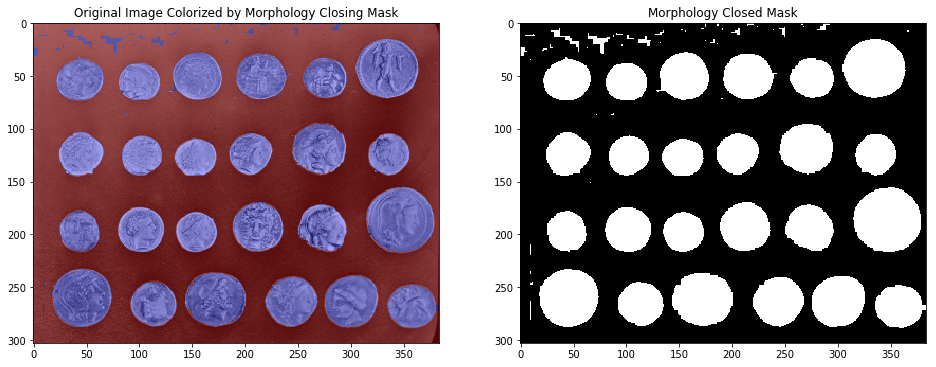

In [5]:
from skimage.morphology import closing
# Remove dark spots and connect bright cracks
closed_mask = closing(clear_boundary_mask,selem=np.ones((7,7)))
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.title('Original Image Colorized by Morphology Closing Mask')
plt.imshow(l2rgb(closed_mask,coin_im))
plt.subplot(122)
plt.title('Morphology Closed Mask')
plt.imshow(closed_mask,cmap='gray')

### Label Regions in image. For each, extract centroid position, area and eccentricity.

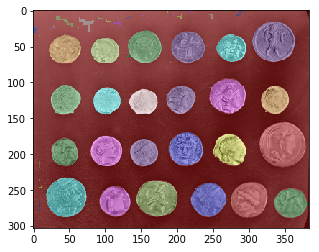

In [6]:
from skimage.measure import label,regionprops 

# segment image
label_mask = label(closed_mask)
labels = regionprops(label_mask,intensity_image=coin_im) 

# plot labelled images:
plt.imshow(l2rgb(label_mask,coin_im))

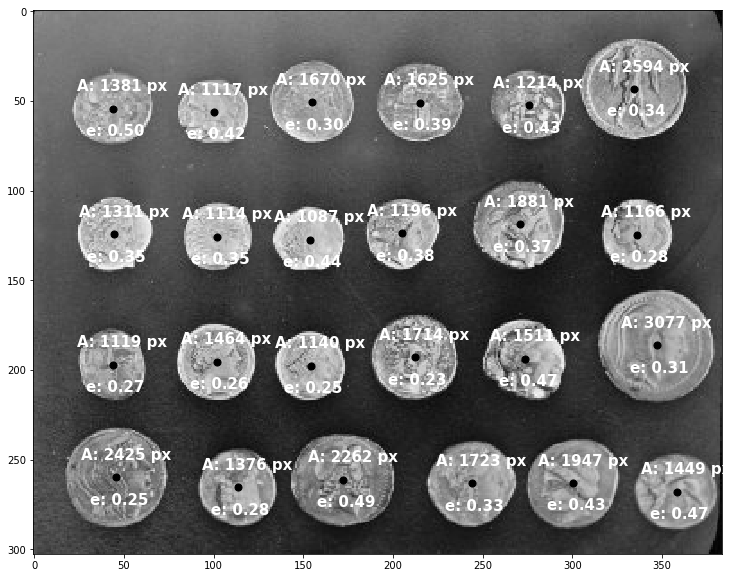

In [7]:
centroids,areas,eccentricity = [],[],[]
for el in np.arange(len(labels)) : 
    centroids.append(labels[el].centroid)
    areas.append(labels[el].area)
    eccentricity.append('%0.2f' % labels[el].eccentricity)
    
# Sort by area and take the 20 largest since there are 20 coins
inds = np.argsort(areas).astype(int)[-24:]
coin_centroids = np.array(centroids)[inds]
coin_areas = np.array(areas)[inds]
coin_eccs = np.array(eccentricity)[inds]

# Plot info on top of original image by coin centroid.
plt.figure(figsize=(15,10))
plt.imshow(coin_im,cmap='gray')
for i in np.arange(len(inds)) : 
    plt.scatter(coin_centroids[i][1],coin_centroids[i][0],marker='o',s=50,color='black')
    plt.text(coin_centroids[i][1]-20,coin_centroids[i][0]-10,'A: '+str(coin_areas[i])+' px',
             fontdict={'color':'white','fontsize':15,'weight':'bold'})
    plt.text(coin_centroids[i][1]-15,coin_centroids[i][0]+15,'e: '+str(coin_eccs[i]),
             fontdict={'color':'white','fontsize':15,'weight':'bold'})

A : Area in pixels

e : eccentricity: 0 -> circle, >0 -> more eliptical

## Problem 2 Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

## Solution

### Read in images to be stitched together from directory and preprocess by converting to grey and resizing.

In [8]:
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import glob
image_ls = sorted(glob.glob('pano_ims/*.jpg'))
# Read in to grayscale
pano_ims = [rgb2gray(io.imread(name)) for name in image_ls]
# Downsize by a factor of 4
pano_ims = [resize(im, (im.shape[0]/2.,im.shape[1]/2.),mode='constant') for im in pano_ims]

### Display the images

(-0.5, 2015.5, 1511.5, -0.5)

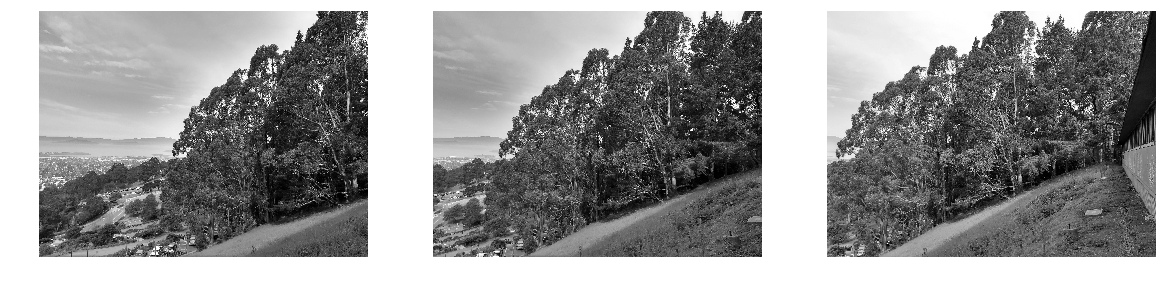

In [9]:
plt.figure(figsize=(20,15))
ax=plt.subplot(131)
plt.imshow(pano_ims[0],cmap='gray')
ax.axis('off')
ax=plt.subplot(132)
plt.imshow(pano_ims[1],cmap='gray')
ax.axis('off')
ax=plt.subplot(133)
plt.imshow(pano_ims[2],cmap='gray')
ax.axis('off')

### Following tutorial, retrieve ORB features for each image 

In [10]:
from skimage.feature import ORB,plot_matches

orb = ORB(n_keypoints=800, fast_threshold=0.05)

keypoints = []
descriptors = []

print('Extracting ORB Features from :')
i=0
for im in pano_ims[:3] :
    print(image_ls[i])
    orb.detect_and_extract(im)
    keypoints.append(orb.keypoints)
    descriptors.append(orb.descriptors)
    i+=1

Extracting ORB Features from :
pano_ims/IMG_20180409_095425057_HDR.jpg
pano_ims/IMG_20180409_095427982_HDR.jpg
pano_ims/IMG_20180409_095432575_HDR.jpg


### Define middle image as reference, and match features between it and the other images

In [11]:
from skimage.feature import match_descriptors

# Match descriptors between source images and target image (middle of series)
matches01 = match_descriptors(descriptors[0], descriptors[1], cross_check=True)
matches12 = match_descriptors(descriptors[1], descriptors[2], cross_check=True)

/home/samuel_badman/anaconda3/lib/python3.6/site-packages/skimage/feature/match.py:49: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  if np.issubdtype(descriptors1.dtype, np.bool):


### Filter out false matches with RANSAC algorithm

In [12]:
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform

# Identify matching features in source image and target image
src,targ= keypoints[0][matches01[:,0]][:,::-1],keypoints[1][matches01[:,1]][:,::-1]
# Filter matching features with ransac:
# Fit a projective transform model (find transformation which maps source image onto target image)
# Try many different subsets of the above data and choose the subset which has the most inliers to the model
model01, inliers01 = ransac((src,targ),ProjectiveTransform,min_samples=4,residual_threshold=1,max_trials=300)

# Repeat for other source target pair :
src,targ= keypoints[2][matches12[:,1]][:,::-1],keypoints[1][matches12[:,0]][:,::-1]
model12, inliers12 = ransac((src,targ),ProjectiveTransform,min_samples=4,residual_threshold=1,max_trials=300)

__Plot the ORB matches before and after the ransac imaging__

Text(0.5,1,'RANSAC filtered feature matches')

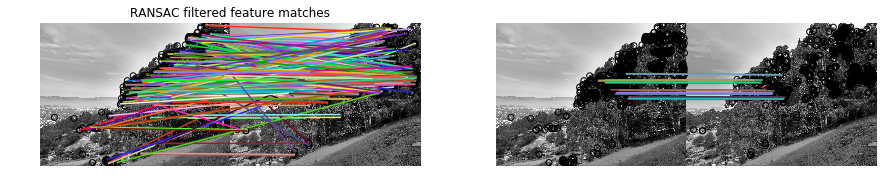

In [13]:
fig = plt.figure(figsize=(15, 12))

axl = fig.add_subplot(121)
plot_matches(axl, pano_ims[0], pano_ims[1], keypoints[0], keypoints[1], matches01)
axl.axis('off');
axl.set_title('Full ORB feature matches')

axr = fig.add_subplot(122)
plot_matches(axr, pano_ims[0], pano_ims[1], keypoints[0], keypoints[1], matches01[inliers01])
axr.axis('off');
axl.set_title('RANSAC filtered feature matches')

### Stitch images together by warping

In [14]:
from skimage.transform import warp, SimilarityTransform
import numpy as np

# Get shape of output panorama by warping the source images to the middle
# and finding the max and min coordinates of the corners of all 3 images.
# I just use the exact method from the notebook here as the vstack, np.min
# method is much more concise than anything I can think of.
r, c = pano_ims[1].shape[:2]
corners = np.array([[0, 0],[0, r],[c, 0],[c, r]])
warp01,warp12 = model01(corners),model12(corners)
all_corners = np.vstack((warp01, warp12, corners))
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)
output_shape = np.ceil(output_shape[::-1]).astype(int)

In [15]:
# Translate center image to the middle of the panorama
center_offset = SimilarityTransform(translation=-corner_min)
pano_center = warp(pano_ims[1],center_offset.inverse,
                   order=0,output_shape=output_shape,cval=-1)
# Get mask locating center image within the panorama, set background values
# in panorama to 0
center_mask = (pano_center != -1)
pano_center[pano_center == -1] = 0

# Warp left and right images into place using ransac derived transformation
#Left
transform01 = (model01+center_offset).inverse
pano_left = warp(pano_ims[0],transform01,
                   order=0,output_shape=output_shape,cval=-1)
left_mask = (pano_left != -1)
pano_left[pano_left == -1] = 0
#Right
transform12 = (model12+center_offset).inverse
pano_right = warp(pano_ims[2],transform12,
                   order=0,output_shape=output_shape,cval=-1)
right_mask = (pano_right != -1)
pano_right[pano_right == -1] = 0

__Plot each image within the panorama frame to illustrate the warping__

(-0.5, 3323.5, 2017.5, -0.5)

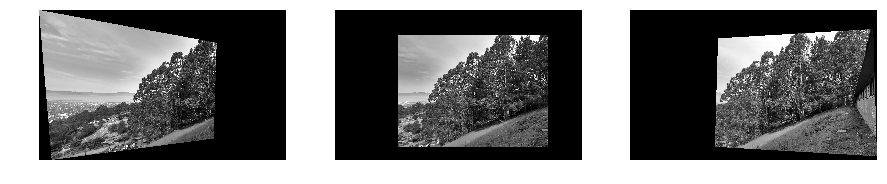

In [16]:
plt.figure(figsize=(15,10))
ax = plt.subplot(131)
plt.imshow(pano_left,cmap='gray')
ax.axis('off')
ax=plt.subplot(132)
plt.imshow(pano_center,cmap='gray')
ax.axis('off')
ax=plt.subplot(133)
plt.imshow(pano_right,cmap='gray')
ax.axis('off')

## Combining the images along a minimum-cost path

We will generate a minimum cost path connecting the top of the image and the bottom of the image, one to the left of 
center, and one to the right of center. This path will trace a contour which defines a transition between images, along
which the difference in the images is as close to 0 as possible. Using the contour between the left and center image
image as an example, we ise this contour to only take pixels from the left image which are left of this mask, and only 
take pixels from the center image which are right of the mask. Then when adding them together, the boundary pixels are
divided by 2 but because that path is 0 difference, there will not be a significant artifact present in the final image.

In [17]:
# The contour requries boundary points to connect. Although these will vary in the function below, they must be initialized
ymax,xmax = output_shape[1] - 1, output_shape[0] - 1
# Left-center boundary seed [[bottom of image],[top of image]]
seed_01 = [[0.,int(ymax/4.)],[xmax,int(ymax/4.)]]
# Right-center boundary seed [[bottom of image],[top of image]]
seed_12 = [[0.,int(3.*ymax/4.)],[xmax,int(3.*ymax/4.)]]

First define a cost function defined over the intersection of the two images being stitched together. The cost for the path should be lower the closer to matching the image intersections are, i.e. so that the lowest cost path threads the
0 differences in the image as much as possible.

In [18]:
# Use cost array function defined in example notebook:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

In [19]:
# Initialize cost functions
#Intersection of left and center images
mask01 = left_mask & center_mask
costs01 = generate_costs(np.abs(pano_center - pano_left),mask01)
costs01[0,:],costs01[-1,:] = 0,0 #No cost for allowing top and bottom boundary of the path slide
#Intersection of left and center images
mask12 = center_mask & right_mask
costs12 = generate_costs(np.abs(pano_center - pano_left),mask12)
costs12[0,:],costs12[-1,:] = 0,0 #No cost for allowing top and bottom boundary of the path slide

In [20]:
# Use route through array to find a contour whos sum over the cost values calculated above is minimized

from skimage.graph import route_through_array
pts01,_ = route_through_array(costs01,seed_01[0],seed_01[1],fully_connected=True)
costs12[mask01 > 0] = 1 # Stop graphs intersecting
pts12,_ = route_through_array(costs12,seed_12[0],seed_12[1],fully_connected=True)
pts01,pts12 = np.array(pts01),np.array(pts12)

__Visualize the least cost paths__

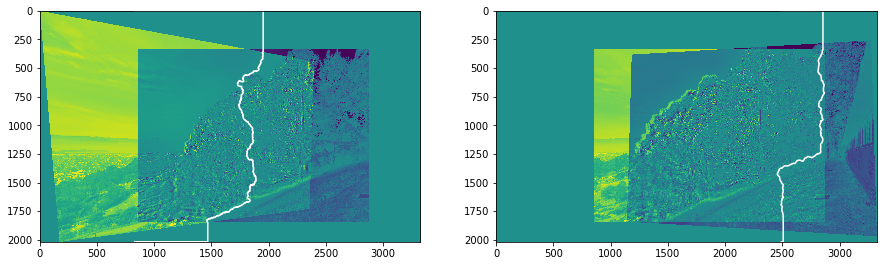

In [21]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(121)
ax.imshow(pano_left-pano_center)
ax.plot(pts01[:,1],pts01[:,0],color='white')
ax = fig.add_subplot(122)
ax.imshow(pano_center-pano_right)
ax.plot(pts12[:,1],pts12[:,0],color='white')

__ Generate Masks __ 

(1) 1s to the left of the left-center least cost path

(2) 1s to the right of the center-right least cost path

In [22]:
# Left-center
# Empty array
mask0 = np.zeros_like(pano_left,dtype=np.uint8)
# Put in left-center least cost path
mask0[pts01[:,0],pts01[:,1]]=1
# Split image into 2 regions based on this dividing line
mask0 = (label(mask0,connectivity=1,background=-1)==1) # Take region 1 (left of boundary)

#Center-right
# Empty array
mask2 = np.zeros_like(pano_right,dtype=np.uint8)
# Put in left-center least cost path
mask2[pts12[:,0],pts12[:,1]]=1
# Split image into 2 regions based on this dividing line
mask2 = ~(label(mask2,connectivity=1,background=-1)==1) # Take region 2 (right of boundary)
# Center mask : 0 everywhere left and right masks are non-zero
mask1 = ~(mask0 | mask2).astype(bool)


__ Finally add all 3 images multiplied by their respective masks __

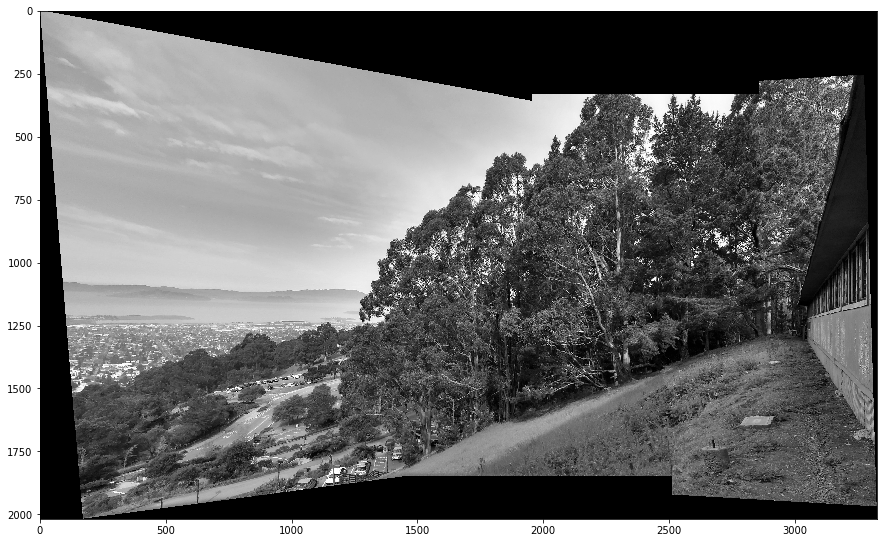

In [23]:
pano_final = pano_left*mask0 + pano_center*mask1 + pano_right*mask2

from skimage.color import gray2rgb

plt.figure(figsize= (15,10))
ax = plt.subplot(111)
ax.imshow(pano_final,interpolation='none',cmap='gray')

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.